# what is the PCA & LDA?
  we have to algorithm without using the python libraries.


In [66]:
# google drive. so we have to monunt
from google.colab import drive # /content/drive/MyDrive/project/MachineLearning/dataset/mnist.pkl
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['random', 'eigh']
`%matplotlib` prevents importing * from pylab and numpy



In [68]:
# load data. I load 
import six.moves.cPickle as pickle
import gzip
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import seaborn as sns

In [69]:
def load_data(dataset): # data load : HDLMS source code utilize
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join(
            os.path.split('/content/drive/MyDrive/project/MachineLearning/dataset/')[0],
            dataset
        )
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from six.moves import urllib
        origin = (
            'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        )
        print('Downloading data from %s' % origin)
        urllib.request.urlretrieve(origin, dataset)

    print('... loading data')

    # Load the dataset
    with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)
    # train_set, valid_set, test_set format: tuple(input, target)
    # input is a numpy.ndarray of 2 dimensions (a matrix)
    # where each row corresponds to an example. target is a
    # numpy.ndarray of 1 dimension (vector) that has the same length as
    # the number of rows in the input. It should give the target
    # to the example with the same index in the input.

    return train_set, valid_set, test_set

In [70]:
if __name__ == '__main__':
    train_set, val_set, test_set = load_data('mnist.pkl.gz')

    train_x, train_y = train_set
    val_x, val_y = val_set
    test_x, test_y = test_set
    
    print(train_x.shape)
    print(train_y.shape)

... loading data
(50000, 784)
(50000,)


No handles with labels found to put in legend.


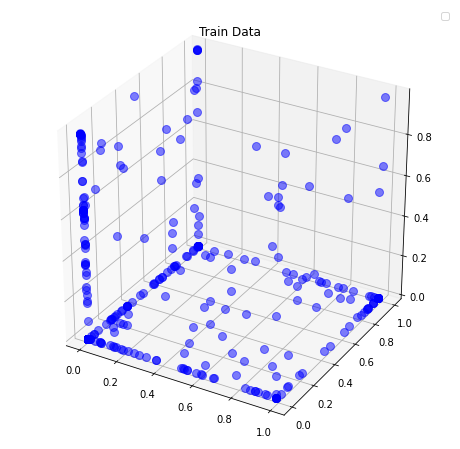

In [71]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(train_x[0,:], train_x[1,:], train_x[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='')
#ax.plot(class2_sample[0,:], class2_sample[1,:], class2_sample[2,:], '^', markersize=8, alpha=0.5, color='red', label='class2')

plt.title('Train Data')
ax.legend(loc='upper right')

plt.show()

Text(0.5, 1.0, 'ImageData prob density graph')

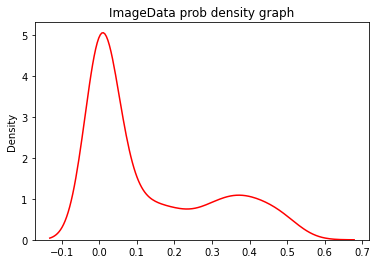

In [72]:
sns.kdeplot(np.mean(train_x, axis = 0), color= 'red')
plt.title("ImageData prob density graph")

In [73]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(train_x)
print(standardized_data.shape)

(50000, 784)


In [74]:
sample_data = standardized_data

# matrix multiplication using numpy
covar_matrix = np.matmul(sample_data.T , sample_data)

print ( "The shape of co-variance matrix = ", covar_matrix.shape)

The shape of co-variance matrix =  (784, 784)


In [75]:
# the parameter 'eigvals' is defined (low value to high value) 
# eigh function will return the eigen values in asending order
# this code generates only the top 2 (782 and 783) eigenvalues.
from scipy.linalg import eigh
values, vectors = eigh(covar_matrix, eigvals=(782,783))

print("Shape of eigen vectors = ",vectors.shape)
# converting the eigen vectors into (2,d) shape for easyness of further computations
vectors = vectors.T

print("Updated shape of eigen vectors = ",vectors.shape)
# here the vectors[1] represent the eigen vector corresponding 1st principal eigen vector
# here the vectors[0] represent the eigen vector corresponding 2nd principal eigen vector

Shape of eigen vectors =  (784, 2)
Updated shape of eigen vectors =  (2, 784)


In [76]:
# projecting the original data sample on the plane 
# formed by two principal eigen vectors by vector-vector multiplication.

new_coordinates = np.matmul(vectors, sample_data.T)

print (" resultanat new data points' shape ", vectors.shape, "X", sample_data.T.shape," = ", new_coordinates.shape)

 resultanat new data points' shape  (2, 784) X (784, 50000)  =  (2, 50000)


In [77]:
print(new_coordinates.T)

[[-4.9018493 -0.9425231]
 [-7.854966   8.674057 ]
 [ 9.281881   2.3759604]
 ...
 [ 3.127304  -3.651585 ]
 [ 1.0985146 -5.3069134]
 [ 6.666811  -3.2738593]]


In [78]:
import pandas as pd

# appending label to the 2d projected data
new_coordinates = np.vstack((new_coordinates,  train_y)).T

# creating a new data frame for ploting the labeled points.
dataframe = pd.DataFrame(data=new_coordinates, columns=("1st_principal", "2nd_principal", "label"))
print(dataframe.head())

   1st_principal  2nd_principal  label
0      -4.901849      -0.942523    5.0
1      -7.854966       8.674057    0.0
2       9.281881       2.375960    4.0
3      -3.597167      -6.651203    1.0
4       2.863719      -5.128342    9.0


In [79]:
import plotly.express as px

In [80]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # Mean centering
        self.mean = np.mean(X, axis=0)
        X = X - self.mean

        # covariance, function needs samples as columns
        cov = np.cov(X.T)

        # eigenvalues, eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov)

        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvectors
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

      
        # store first n eigenvectors
        self.components = eigenvectors[0 : self.n_components]

    def transform(self, X):
        # project data
        X = X - self.mean
        return np.dot(X, self.components.T)



Shape of X: (50000, 784)
Shape of transformed X: (50000, 2)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: ComplexWarning:

Casting complex values to real discards the imaginary part



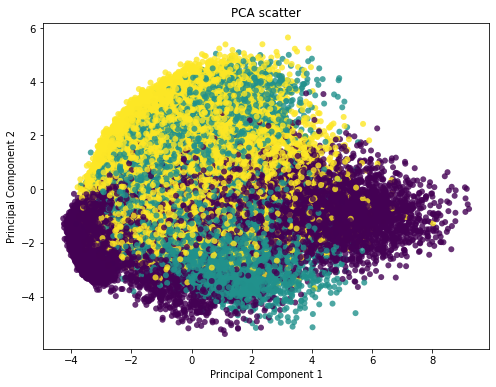

In [81]:
if __name__ == "__main__":
    # Imports
    import matplotlib.pyplot as plt

    # Project the data onto the 2 primary principal components
    pca = PCA(2)
    pca.fit(train_x)
    X_projected = pca.transform(train_x)

    print("Shape of X:", train_x.shape)
    print("Shape of transformed X:", X_projected.shape)

    x1 = X_projected[:, 0]
    x2 = X_projected[:, 1]
    plt.figure(figsize= (8, 6))
    plt.scatter(
        x1, x2, c=train_y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)
    )
    plt.title("PCA scatter")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
  
    plt.show()

In [88]:
class LDA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.eig_vectors = None
    
    def transform(self,X,y):
        height, width = X.shape
        unique_classes = np.unique(y)
        num_classes = len(unique_classes)

        scatter_t = np.cov(X.T)*(height - 1)
        scatter_w = 0
        for i in range(num_classes):
            class_items = np.flatnonzero(y == unique_classes[i])
            scatter_w = scatter_w + np.cov(X[class_items].T) * (len(class_items)-1)
        
        scatter_b = scatter_t - scatter_w
        _, eig_vectors = np.linalg.eigh(np.linalg.pinv(scatter_w).dot(scatter_b))
        print(eig_vectors.shape)
        pc = X.dot(eig_vectors[:,::-1][:,:self.n_components])
        print(pc.shape)

        if self.n_components == 2:
            if y is None:
                plt.scatter(pc[:,0],pc[:,1])
            else:
                plt.figure(figsize=(8, 8))
                colors = ['red','green','blue', 'pink', 'black', 'orange', 'gray', 'yello', 'indigo']
                labels = np.unique(y)
                for color, label in zip(colors, labels):
                  #plt.figure(figsize=(8, 8))
                  class_data = pc[np.flatnonzero(y==label)]
                  c0 = class_data[:, 0]
                  c1 = class_data[:, 1]
                  plt.scatter(c0, c1, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3))
                   # plt.scatter(class_data[:,0],class_data[:,1],c=color)

            plt.title("LDA scatter")
            plt.xlabel("LDA1")
            plt.ylabel("LDA2")
            plt.show()
        return pc


(784, 784)
(50000, 2)


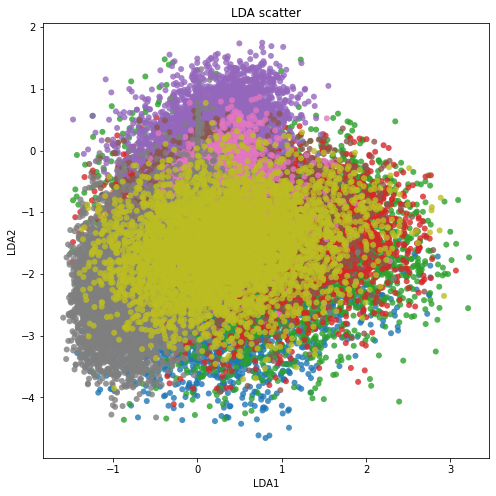

Original Data Size: (50000, 784) 
Modified Data Size: (50000, 2)


In [89]:

LDA_obj = LDA(n_components=2)
LDA_object = LDA(n_components=2)
X_train_modified = LDA_object.transform(train_x, train_y)

print("Original Data Size:",train_x.shape, "\nModified Data Size:", X_train_modified.shape)

In [ ]:
cov = train_x.T.dot(train_x) / train_x.shape[0]
meanX = train_x.T.mean(1).reshape((-1, 1))
meanY = train_x.mean(0).reshape((-1, 1))
_cov = cov - meanX.dot(meanY.T)
eigval, eigvec = np.linalg.eig(_cov)

In [ ]:
print(eigval)

[ 5.10819054e+00  3.70090580e+00  3.25861311e+00  2.82002807e+00
  2.54668379e+00  2.26442194e+00  1.71816611e+00  1.51309669e+00
  1.45147538e+00  1.24026418e+00  1.10060787e+00  1.05913508e+00
  8.99450123e-01  8.81628513e-01  8.27881575e-01  7.82529354e-01
  6.91008151e-01  6.69193387e-01  6.21993005e-01  6.03386700e-01
  5.60445845e-01  5.28150320e-01  4.99910742e-01  4.75918263e-01
  4.62774128e-01  4.38745439e-01  4.28570300e-01  4.11404908e-01
  3.88977766e-01  3.62081051e-01  3.45231056e-01  3.37415129e-01
  3.15956503e-01  3.06826890e-01  2.98506349e-01  2.84049273e-01
  2.65940994e-01  2.56025523e-01  2.52702057e-01  2.48139113e-01
  2.39028931e-01  2.31395841e-01  2.18299195e-01  2.07706660e-01
  2.01998025e-01  1.96091741e-01  1.89415514e-01  1.83722556e-01
  1.78375781e-01  1.68298736e-01  1.66807324e-01  1.63025528e-01
  1.54420331e-01  1.51127592e-01  1.49792001e-01  1.41936913e-01
  1.41131997e-01  1.34395391e-01  1.33097053e-01  1.27665758e-01
  1.26073346e-01  1.24637

In [ ]:
print(eigvec)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
mu_vec1 = np.array(meanX)
cov_mat1 = np.array(_cov)

In [ ]:
#sort the eigenvalues in descending order
sorted_index = np.argsort(eigval)[::-1]
sorted_eigenvalue = eigval[sorted_index]
#similarly sort the eigenvectors 
sorted_eigenvectors = eigvec[:,sorted_index]

In [ ]:
# select the first n eigenvectors, n is desired dimension
# of our final reduced data.
 
n_components = 2 #you can select any number of components.
eigenvector_subset = sorted_eigenvectors[:,0:n_components]

In [ ]:
print(eigenvector_subset)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [ ]:
xmeaned = train_x - np.mean(train_x, axis = 0)

In [ ]:
#Transform the data 
X_reduced = np.dot(eigenvector_subset.transpose(), xmeaned.transpose()).transpose()
print(X_reduced)

[[ 0.46150973 -1.2468646 ]
 [ 3.921652   -1.2516513 ]
 [-0.203711    1.547883  ]
 ...
 [-1.4250613  -1.957856  ]
 [-1.5074272   1.0253141 ]
 [-1.3963965  -0.6464827 ]]


In [ ]:
import pandas as pd

principal_df = pd.DataFrame(X_reduced, columns = ['PC1','PC2'])

In [ ]:
principal_df.head()

,PC1,PC2
0,0.461510,-1.246865
1,3.921652,-1.251651
2,-0.203711,1.547883
3,-3.148448,-2.296119
4,-1.442680,2.872079


In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
 
plt.figure(figsize = (6,6))
sb.scatterplot(data = principal_df , x = 'PC1',y = 'PC2' , hue = 'target' , s = 60 , palette= 'icefire')


In [ ]:
import plotly.express as px

fig = px.scatter(principal_df, x="PC1", y="PC2", color = principal_df["PC2"], title = "PC1 and PC2 scatter", width = 800, height= 600 )
fig.show()